# CSCI 5922 (Spring 2020) Final Project
name: Timothy Mason
***
Music Genre classification

todo: fill in citations and flesh out overview

last.fm dataset citation, as required in the terms of usage at
http://millionsongdataset.com/

```
@INPROCEEDINGS{Bertin-Mahieux2011,
  author = {Thierry Bertin-Mahieux and Daniel P.W. Ellis and Brian Whitman and Paul Lamere},
  title = {The Million Song Dataset},
  booktitle = {{Proceedings of the 12th International Conference on Music Information
	Retrieval ({ISMIR} 2011)}},
  year = {2011},
  owner = {thierry},
  timestamp = {2010.03.07}
}
```


## Imports and Colab Setup If Needed

Note:  For this to work in Google Colab, you must clone the entire Git repo to the folder 'Colab Notebooks/final_timothy_mason_csci5922_s20/' in YOUR gDrive.

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    print("Setting up for execution in Google Colab")
    %tensorflow_version 2.x
    from google.colab import drive
    drive.mount('/content/drive')

    %cd '/content/drive/My Drive/Colab Notebooks/final_timothy_mason_csci5922_s20'
    
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import os
from pathlib import Path
import json

if IN_COLAB:
    from tqdm.auto import tqdm
else:
    from tqdm import tqdm      # for easy and attractive progress bars

import hdf5_getters        # https://github.com/tbertinmahieux/MSongsDB/tree/master/PythonSrc
# hdf5_getters.py is Copyright 2010, Thierry Bertin-Mahieux
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

Setting up for execution in Google Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/final_timothy_mason_csci5922_s20


## Hyperparameters

In [0]:
segments = 252    # Minimum usable segment count
pickle_fn = f'./msd_subset_top50_{segments}.pickle'

input_shape = (segments, 12, 1)
channel_axis = 3
freq_axis = 2
time_axis = 1

# Hyperparms adapted from Choi, et. al for their 3,000,000 parameter size CRNN model
CNN_dropout = 0.1
# CNN1_N = 169
# CNN1_kernel = (3,3)
# CNN1_pool = (2,2)

CNN2_N = 339
CNN2_kernel = (3,3)
CNN2_pool = (2,2)

CNN3_N = 339
CNN3_kernel = (3,3)
CNN3_pool = (2,2)

CNN4_N = 339
CNN4_kernel = (3,3)
CNN4_pool = (3,3)

RNN_dropout = 0.3
RNN1_N = 169
RNN2_N = 169

training_batch_size=10
training_epochs=100

# # Hyperparms adapted from Choi, et. al for their 100,000 parameter size CRNN model
# CNN_dropout = 0.1
# # CNN1_N = 30
# # CNN1_kernel = (3,3)
# # CNN1_pool = (2,2)

# CNN2_N = 60
# CNN2_kernel = (3,3)
# CNN2_pool = (2,2)

# CNN3_N = 60
# CNN3_kernel = (3,3)
# CNN3_pool = (2,2)

# CNN4_N = 60
# CNN4_kernel = (3,3)
# CNN4_pool = (3,3)

# RNN_dropout = 0.3
# RNN1_N = 30
# RNN2_N = 30

# training_batch_size=10
# training_epochs=50

## Import data functions

In [0]:
# see http://docs.echonest.com.s3-website-us-east-1.amazonaws.com/_static/AnalyzeDocumentation.pdf for
# detailed discussion of the category data items
def hdf_tree_to_dataframe(msd_path='./MillionSongSubset/data',
                          categories=("track_id",
                                      "artist_name",          # Name of the artist
                                      "release",              # Album name
                                      "title",                # Title of the piece
                                      "year",                 # year released (unreliable - often 0)
                                      "segments_pitches",     # list of 12-ary vectors, each contains relative
                                                              # strength of the notes (pitches) contained in 
                                                              # a segment.  0 = strength(0..1) of the C note, 
                                                              # 1 = strength of C-sharp, 
                                                              # ... 
                                                              # 11 = B
                                      "segments_timbre",      # list of 12-ary vectors, "timbre is the quality
                                                              # of a musical note or sound that distinguishes 
                                                              # different types of musical instruments, or 
                                                              # voices. It is a complex notion also referred 
                                                              # to as sound color, texture, or tone quality, 
                                                              # and is derived from the shape of a segment’s 
                                                              # spectro-temporal surface, independently of 
                                                              # pitch and loudness. "
                                     ), 
                          first = 0, last = None):
    """
    Walk the directory structure of the provided path, and read data from the
    *.h5 files in all subdirectories.

    Parameters
    ----------
    categories: set of keyword strings.  Note:  'track_id' is the index field, so it will always read
        that category, whether it is specified or not.
    msd_path: The path to the root directory of the MSD dataset
    first: Index of the first file to read
    last: Index of the last file to read.  If None, then read entire list of files

    Returns
    -------
    a Pandas dataframe object containing the specified categories of MSD data
    """

    file_list = [f for f in Path(msd_path).glob('**/*.h5')]

    if last == None:
        last = len(file_list)
    data = []

    for f in tqdm(file_list[first:last], desc=f"Loading subset of MSD"):
        h5file = hdf5_getters.open_h5_file_read(f)
        d = {}
        for c in categories:
            t = getattr(hdf5_getters, "get_"+c)(h5file)
            # Truncate segments to fixed size
            if c=='segments_pitches':
                d[c] = t[:segments]
            elif c=='segments_timbre':
                d[c] = t[:segments]
            else:
                d[c] = t
        h5file.close()
        
        # Only keep records with at least the minimum number of segments
        if len(d['segments_pitches']) >= segments:
            data.append(d)
            
    return pd.DataFrame(data)

def json_tree_to_dataframe( lfm_path='./lastfm_subset' ):
    """
    Load the tags from all JSON files at the specified directory and its' subdirectories
    into a Pandas DataFrame.  Index by track_id and also keep artist and title for more precise matching
    to the MSD.  Result is filtered to only return entries which have tags in the top-50.  Assumes that
    the list of last.fm top 50 tags is in the file top50_lastfm_tags.csv in the current working directory.
    
    Parameters
    ----------
    lfm_path: The path to the root directory of the last.fm dataset

    Returns
    -------
    a Pandas DataFrame object containing the entire dataset, filtered to only contain entries which
    have tags in the top 50 of last.fm tags.
    """
    
    # load the top 50 tags into a set because set intersection will be an elegant way to only keep those
    # tags which are in the top 50.
    top50 = set(pd.read_csv('top50_lastfm_tags.csv').Tag)
    
    # Appending one record at a time to a Pandas DataFrame is inefficient, so build a simple list
    # in memory, then create the Pandas DataFrame in one shot from that list
    data = []
    for file_path in tqdm([f for f in Path(lfm_path).glob('**/*.json')], desc="Loading last.fm tags"):
        with open(file_path) as json_data:     # with... syntax benefits from automatic file closing
            j = json.load(json_data)
            
            # change the key for the name of the artist to have consistent naming with the MSD
            j['artist_name'] = j.pop('artist') 
            
            if j['tags']:      # skip tag-less entries
                # Only keep the tags, and only if they are in the top50 set.  Do the list filtering by
                # using set intersection of the top50 set and use column slice feature of a numpy array to
                # extract just the tag names.  (The JSON file has both the tag name and an integer number
                # for each tag - I don't need that integer number)
                t = list(top50.intersection(np.array(j['tags'])[:,0]))
                if t:
                    j['top50_tags'] = t
                    data.append(j)
    
    return pd.DataFrame(data)[['track_id','artist_name','title','top50_tags']] # only keep the useful bits


## Load and merge the datasets

Loading the MSD subset from the h5 file tree takes several minutes (or hours on Colab).  
Save time on reruns by saving a snapshot of a fully loaded and filtered dataset to a Python pickle file.

Recommended trick:  Load this notebook locally on your computer and use a local instance to generate pickle files.  Then upload those pickle files to gDrive so you can use the fast tensorflow on Colab with GPUs and not wait hours for the data load from the small files.  (sorry, the pickle files are too large to be stored in github)

In [0]:
import os.path

if os.path.isfile(pickle_fn):
    # This dataset has already been generated.  Load the snapshot
    df = pd.read_pickle(pickle_fn)
else:
    if IN_COLAB:
        print("Have patience, please.  Loading data from gDrive is VERY slow because MANY small files")
    # A snapshot is not available for this dataset.  Load it then save the snapshot
    lfm_df = json_tree_to_dataframe()
    msd_df = hdf_tree_to_dataframe()
    df = msd_df.merge( right=lfm_df, on=('track_id','title','artist_name') )

    # Allow the interim dataframes to be garbage collected
    msd_df = lfm_df = None

    df.to_pickle(pickle_fn)
    print(f"Created snapshot file {pickle_fn}")


### Inspect the final dataset

In [5]:
df

,track_id,artist_name,release,title,year,segments_pitches,segments_timbre,top50_tags
0,TRARRER128F9328521,Brand X,X Communication : Trilogy II,Liquid Time (composition by John Goodsall),0,"[[0.253, 0.295, 0.256, 0.255, 0.365, 0.256, 0....","[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...",[chill]
1,TRARREF128F422FD96,Dead Kennedys,Milking The Sacred Cow,Halloween,1982,"[[0.146, 0.203, 0.219, 0.209, 0.172, 0.123, 0....","[[23.928, -119.362, 33.96, -122.038, 8.715, 18...","[alternative, punk, 80s, rock, indie, party, a..."
2,TRARUOP12903CF2384,Shadows Fall,The War Within,What Drives The Weak,2004,"[[0.937, 0.557, 0.215, 0.198, 0.112, 0.135, 0....","[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...","[00s, alternative, cool, hard rock, rock, favo..."
3,TRARUHU128F92FDC00,Spoonie Gee,The Sugar Hill Records Story,Spoonie Is Back,0,"[[1.0, 0.284, 0.224, 0.217, 0.245, 0.285, 0.38...","[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...",[80s]
4,TRARIRG128F147FC96,Phil Collins,Face Value,I'm Not Moving,1981,"[[0.819, 0.683, 0.6, 0.67, 0.291, 0.274, 0.689...","[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...","[pop, singer-songwriter, 80s, rock, easy liste..."
...,...,...,...,...,...,...,...,...
2357,TRBBYOI128F4256732,Black Flag,I Can See You,Out Of This World,1985,"[[0.345, 0.254, 0.161, 0.162, 0.25, 0.542, 0.3...","[[0.102, 168.868, 6.486, -31.413, 55.144, -50....","[hard rock, soul, punk]"
2358,TRBBYDT128F14805B4,Phil Collins,Serious Hits... Live!,You Can't Hurry Love (Live),1990,"[[0.521, 0.515, 0.559, 0.631, 0.818, 0.722, 0....","[[33.671, 84.55, 202.282, 2.574, 46.344, 64.34...","[pop, 80s, rock]"
2359,TRBBYFJ128F42A22D4,Jim Reeves,Christmas Songbook,Jingle Bells,1963,"[[1.0, 0.923, 0.508, 0.49, 0.511, 0.522, 0.548...","[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...","[male vocalists, country, easy listening, folk]"
2360,TRBBPGL128F933E34C,Joe Bataan,Call My Name,Ernestine,2005,"[[0.568, 1.0, 0.704, 0.628, 0.761, 0.782, 0.60...","[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...","[chill, soul]"


### Sample Data Visualization

Because it looks cool!

    Song: Distant Voices
  Artist: Atman
 Release: The Lonely Road
Released: 2002
    Tags: ['chillout']


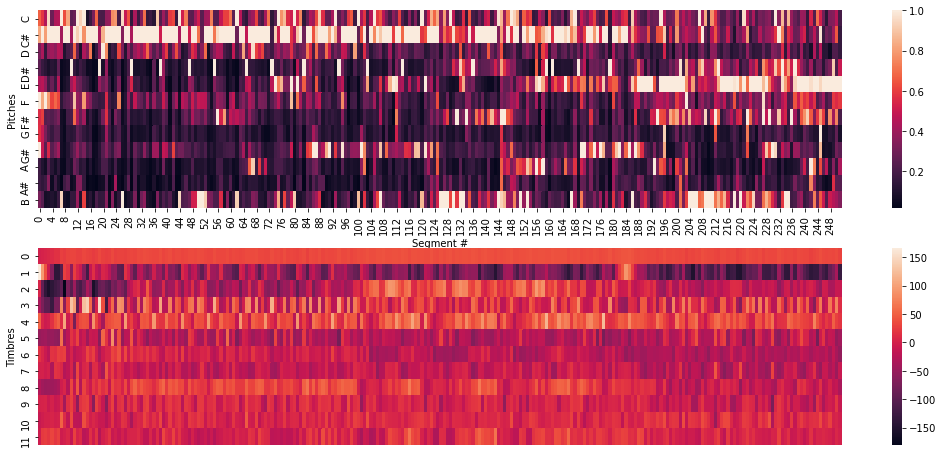

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import random

%matplotlib inline

x = random.randint(0,df.shape[0]-2)

for i in df.index[x:x+1]:
    name = f'    Song: {df.title[i]}\n  Artist: {df.artist_name[i]}\n Release: {df.release[i]}'
    if df.year[i] != 0:
        name += f'\nReleased: {df.year[i]}'
    name += '\n'
    name += f'    Tags: {df.top50_tags[i]}'
    print(name)
    
    # plot a scatterplot of the segment starts
    plt.figure(figsize=(18,8))

    # plot a heatmap of the pitch data
    plt.subplot(2,1,1)
    ax = sns.heatmap(df.segments_pitches[i].T, 
                     yticklabels=("C", "C#", "D", "D#", "E", "F", "F#", "G",
                                 "G#", "A", "A#", "B")
                    )
    ax.set(ylabel="Pitches")
    ax.set(xlabel="Segment #")

    # plot a heatmap of the timbre data
    plt.subplot(2,1,2)
    ax = sns.heatmap(df.segments_timbre[i].T, xticklabels=False)
    ax.set(ylabel="Timbres")
    plt.show()
    plt.close()
    

## Build The CRNN

In [0]:
#
# model adapted from music_tagger_crnn.py at https://github.com/keunwoochoi/music-auto_tagging-keras
#

model = tf.keras.Sequential()

# Input block
model.add(layers.Input(shape=input_shape))
# model.add(layers.ZeroPadding2D(padding=(0, 37)))
model.add(layers.BatchNormalization(axis=freq_axis, name='bn_0_freq'))

# First Convolutional Block
#   Choi et. al, used 4 CNN blocks, but the data set I'm using is too narrow (12 as opposed to 96) to 
#   support 4 blocks, so I'm omitting the first block.
# model.add(layers.Conv2D(filters=CNN1_N, kernel_size=CNN1_kernel, padding='same', name='conv1'))
# model.add(layers.BatchNormalization(axis=channel_axis, name='bn1'))
# model.add(layers.ELU())
# model.add(layers.MaxPool2D(pool_size=CNN1_pool, strides=CNN1_pool, name='pool1'))
# model.add(layers.Dropout(rate=CNN_dropout, name='dropout1'))

# Second Convolutional Block
model.add(layers.Conv2D(filters=CNN2_N, kernel_size=CNN2_kernel, padding='same', name='conv2'))
model.add(layers.BatchNormalization(axis=channel_axis, name='bn2'))
model.add(layers.ELU())
model.add(layers.MaxPool2D(pool_size=CNN2_pool, strides=CNN2_pool, name='pool2'))
model.add(layers.Dropout(rate=CNN_dropout, name='dropout2'))

# Third Convolutional Block
model.add(layers.Conv2D(filters=CNN3_N, kernel_size=CNN3_kernel, padding='same', name='conv3'))
model.add(layers.BatchNormalization(axis=channel_axis, name='bn3'))
model.add(layers.ELU())
model.add(layers.MaxPool2D(pool_size=CNN3_pool, strides=CNN3_pool, name='pool3'))
model.add(layers.Dropout(rate=CNN_dropout, name='dropout3'))

# Fourth convolutional Block
model.add(layers.Conv2D(filters=CNN4_N, kernel_size=CNN4_kernel, padding='same', name='conv4'))
model.add(layers.BatchNormalization(axis=channel_axis, name='bn4'))
model.add(layers.ELU())
model.add(layers.MaxPool2D(pool_size=CNN4_pool, strides=CNN4_pool, name='pool4'))
dropout4 = layers.Dropout(rate=CNN_dropout, name='dropout4') # save this layer for retrieving output shape
model.add(dropout4)

# reshaping
model.add(layers.Reshape(target_shape=(dropout4.output_shape[1], CNN4_N)))

# RNN (GRU) blocks
model.add(layers.GRU(units=RNN1_N, return_sequences=True, name='gru1'))
model.add(layers.GRU(units=RNN2_N, return_sequences=False, name='gru2'))
model.add(layers.Dropout(rate=RNN_dropout))

# Output
model.add(layers.Dense(units=50, activation='sigmoid', name='output'))


### Compile The Model

In [0]:
#
# Compile the model
#
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.AUC()])



### Set up Training Data

In [0]:
from sklearn.preprocessing import MultiLabelBinarizer

# The pitch data is stored as a 1-dim ndarry of lists, but we need a 3D array.  Conversion is adapted from answer #9 at
# https://stackoverflow.com/questions/34156639/tensorflow-python-valueerror-setting-an-array-element-with-a-sequence-in-t/34157312
batch_xs = np.vstack([np.expand_dims(x, 0) for x in df.segments_pitches.values])

X = tf.expand_dims(tf.convert_to_tensor(value=batch_xs, dtype=tf.float32), 3) 

# Use an sklearn convenience utility to create a one-hot encoding of the truth values
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df.top50_tags)
encoded_classes = tuple(mlb.classes_)


### Fit the Model and Show Me The Money

In [10]:
print(f"Input data shape = {X.shape}")
model.fit(X, Y,
          batch_size=training_batch_size,
          epochs=training_epochs,
          verbose=1,
          use_multiprocessing=True,
          validation_split=0.05
         )
model.summary()

Input data shape = (2362, 252, 12, 1)
Epoch 1/100
225/225 [==============================] - 5s 22ms/step - loss: 0.3400 - auc: 0.6012 - val_loss: 0.3404 - val_auc: 0.6067
Epoch 2/100
225/225 [==============================] - 4s 17ms/step - loss: 0.3263 - auc: 0.6287 - val_loss: 0.3445 - val_auc: 0.6045
Epoch 3/100
225/225 [==============================] - 4s 17ms/step - loss: 0.3190 - auc: 0.6563 - val_loss: 0.3221 - val_auc: 0.6820
Epoch 4/100
225/225 [==============================] - 4s 17ms/step - loss: 0.3146 - auc: 0.6707 - val_loss: 0.3182 - val_auc: 0.6981
Epoch 5/100
225/225 [==============================] - 4s 17ms/step - loss: 0.3119 - auc: 0.6830 - val_loss: 0.3187 - val_auc: 0.7006
Epoch 6/100
225/225 [==============================] - 4s 17ms/step - loss: 0.3089 - auc: 0.6952 - val_loss: 0.3167 - val_auc: 0.7063
Epoch 7/100
225/225 [==============================] - 4s 17ms/step - loss: 0.3068 - auc: 0.7017 - val_loss: 0.3259 - val_auc: 0.6929
Epoch 8/100
225/225 [===